# Fraud Detection Data

In [2]:
import warnings
from datetime import datetime
import os
import sys
import json
import pickle

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from geopy.distance import geodesic
from matplotlib import pyplot as plt
from summarytools import dfSummary

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils.plots import FraudMap
from features.feature_engineering import generic_customer_spending_behaviour, general_customer_bahaviour, get_merchant_risk_rolling_window
from features.feature_transformation import encode, categorize_jobs

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


## Load Data

In [3]:
print("Load transaction data")
%time df = pd.read_csv("../data/raw/tr_fincrime_train.csv")
print("{0} transaction data loaded, containing {1} fraudulent transactions".format(len(df),df['is_fraud'].sum()))

Load transaction data
CPU times: user 6.09 s, sys: 977 ms, total: 7.07 s
Wall time: 7.67 s
1296675 transaction data loaded, containing 7506 fraudulent transactions


In [4]:
df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
# a general overview of the dataset
# dfSummary(df)

In [6]:
# %%capture
# df.columns, df.describe(), df.info(), df.isna().sum(), df.duplicated().sum(), df.nunique()

## Univariate Analysis

### Transactions Daily

In [7]:
from data.data_transformation import compute_daily_fraud_stats
daily_fraud_stats = compute_daily_fraud_stats(df)
stats_jason = compute_daily_fraud_stats(df[df['cc_num'] == 4613314721966])

In [8]:
import plotly.express as px
# Plot all three metrics on the same plot
fig = px.line(daily_fraud_stats, x='trans_date', y=['num_transactions_scaled', 'num_fraud_transactions', 'num_fraud_cards'],
              labels={'value': 'Count', 'variable': 'Metric'},
              title='Daily Transactions scaled by 0.01, Fraudulent Transactions, and Fraudulent Cards')
fig.show()

December has the peak transaction volume due to christimas and new year. Transaction volume show a homogenous behaviour on a granular weekly level. And typycally the peak of number of fraud transaction detected is at one week after the peak of transaction volum, meaning that there is (potentially) an average of one week delay. 

### Transaction Density and Sparsity

In [9]:
# Calculate transaction counts
card_counts = df.groupby('cc_num')['amt'].count() 
card_amounts = df.groupby('cc_num')['amt'].sum()
merchant_counts = df.groupby('merchant')['amt'].count() 
merchant_amounts = df.groupby('merchant')['amt'].sum() 

In [10]:
 #Calculate sparsity as average transaction counts per card per day
cards_count_sparsity, per_card_count_sparsity = len(df['trans_date'].unique())/ card_counts, len(df['trans_date'].unique())/ card_counts.mean()
merchants_count_sparsity, per_merchant_count_sparsity = len(df['trans_date'].unique())/ merchant_counts, len(df['trans_date'].unique())/ merchant_counts.mean()

# #Calculate sparsity as average transaction amounts (per card) per day
cards_amount_sparsity, per_card_amount_sparsity = len(df['trans_date'].unique())/ card_amounts, len(df['trans_date'].unique())/ card_amounts.mean()
merchants_amount_sparsity, per_merchant_amount_sparsity = len(df['trans_date'].unique())/ merchant_amounts, len(df['trans_date'].unique())/ merchant_amounts.mean()

print("Card Transaction Count Sparsity:\n", per_card_count_sparsity)
print("\nMerchantTransaction Count Sparsity:\n", per_merchant_count_sparsity)
print("\nCard Transaction Amount Sparsity:\n", per_card_amount_sparsity)
print("\nMerchantTransaction  Amount Sparsity:\n", per_merchant_amount_sparsity)

Card Transaction Count Sparsity:
 0.40709584128636706

MerchantTransaction Count Sparsity:
 0.2869963560645497

Card Transaction Amount Sparsity:
 0.005786636097780993

MerchantTransaction  Amount Sparsity:
 0.004079490148283039


### Transaction Amount

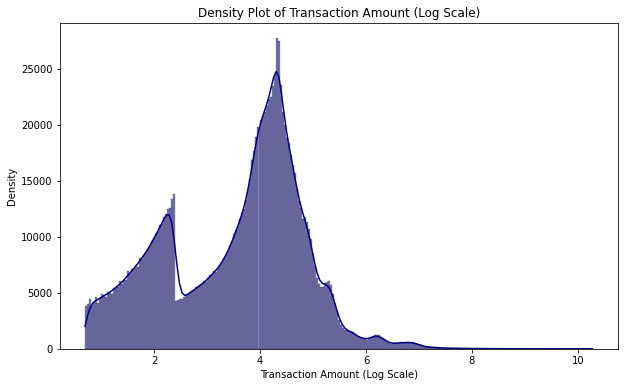

In [11]:
df['scale_amt'] = np.log(df['amt'] + 1)
plt.figure(figsize=(10, 6))
sns.histplot(df['scale_amt'], kde=True, color = 'navy')
plt.title('Density Plot of Transaction Amount (Log Scale)')
plt.xlabel('Transaction Amount (Log Scale)')
plt.ylabel('Density')
plt.show()

### Transaction by Hour, Day of Week, Holiday

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


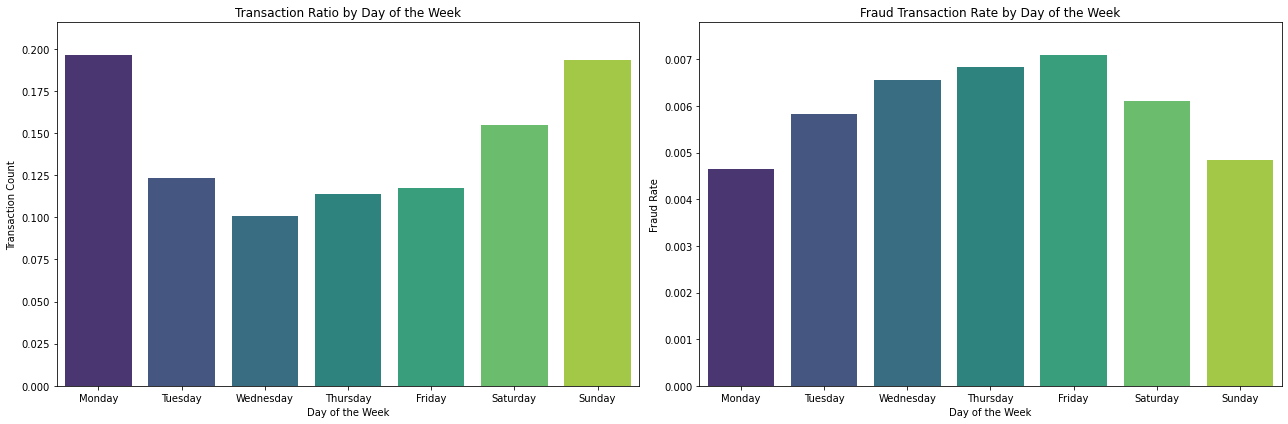

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from features.feature_engineering import general_customer_bahaviour
df = general_customer_bahaviour(df)

transaction_by_day = df.groupby("transaction_day_of_week")['trans_num'].count().reset_index()
transaction_by_day["trans_num"] = transaction_by_day["trans_num"] / transaction_by_day["trans_num"].sum()
fraud_rate_by_day = df.groupby("transaction_day_of_week")['is_fraud'].mean().reset_index()

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

# Plot Transaction Count by Day of the Week
sns.barplot(data=transaction_by_day, x="transaction_day_of_week", y="trans_num", palette="viridis", ax=axes[0])
axes[0].set_title("Transaction Ratio by Day of the Week")
axes[0].set_xlabel("Day of the Week")
axes[0].set_ylabel("Transaction Count")
axes[0].set_xticks(transaction_by_day["transaction_day_of_week"])
axes[0].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axes[0].set_ylim(0, transaction_by_day["trans_num"].max() * 1.1)

# Plot Fraud Rate by Day of the Week
sns.barplot(data=fraud_rate_by_day, x="transaction_day_of_week", y="is_fraud", palette="viridis", ax=axes[1])
axes[1].set_title("Fraud Transaction Rate by Day of the Week")
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("Fraud Rate")
axes[1].set_xticks(fraud_rate_by_day["transaction_day_of_week"])
axes[1].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axes[1].set_ylim(0, fraud_rate_by_day["is_fraud"].max() * 1.1)

# Adjust layout
plt.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


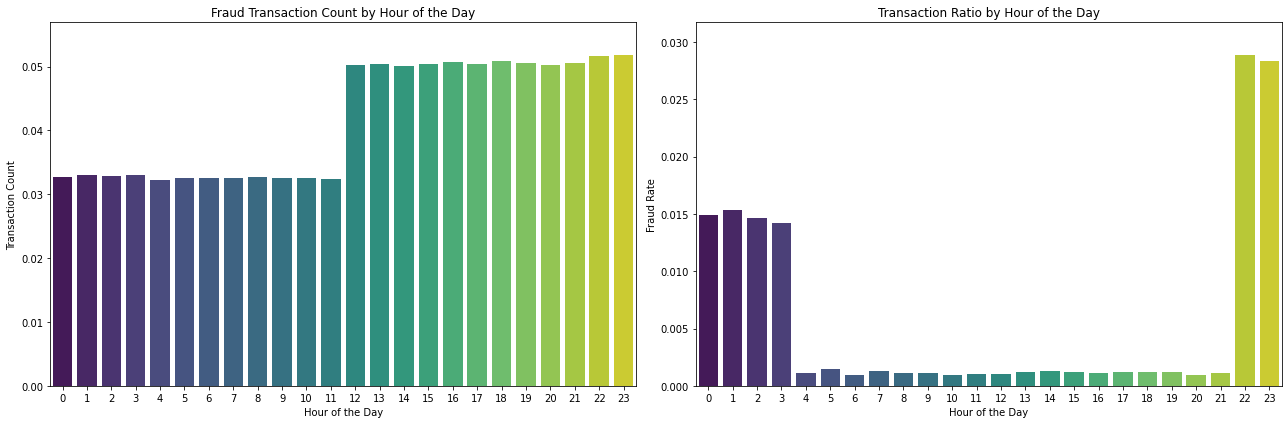

In [13]:
transaction_by_hour_count = df.groupby("transaction_hour")["is_fraud"].count().reset_index()
transaction_by_hour_count["is_fraud"] = transaction_by_hour_count["is_fraud"] / transaction_by_hour_count["is_fraud"].sum()
fraud_rate_by_hour = df.groupby("transaction_hour")["is_fraud"].mean().reset_index()

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

sns.barplot(data=transaction_by_hour_count, x="transaction_hour", y="is_fraud", palette="viridis", ax=axes[0])
axes[0].set_title("Fraud Transaction Count by Hour of the Day")
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Transaction Count")
axes[0].set_xticks(transaction_by_hour_count["transaction_hour"])
axes[0].set_xticklabels(range(24))  # Label with 24-hour format (0-23)
axes[0].set_ylim(0, transaction_by_hour_count["is_fraud"].max() * 1.1)

# Plot Fraud Transaction Rate by Hour of the Day
fraud_rate_by_hour_mean = df.groupby("transaction_hour")["is_fraud"].mean().reset_index()
sns.barplot(data=fraud_rate_by_hour_mean, x="transaction_hour", y="is_fraud", palette="viridis", ax=axes[1])
axes[1].set_title("Transaction Ratio by Hour of the Day")
axes[1].set_xlabel("Hour of the Day")
axes[1].set_ylabel("Fraud Rate")
axes[1].set_xticks(fraud_rate_by_hour_mean["transaction_hour"])
axes[1].set_xticklabels(range(24))  # Label with 24-hour format (0-23)
axes[1].set_ylim(0, fraud_rate_by_hour_mean["is_fraud"].max() * 1.1)
# Adjust layout
plt.tight_layout()
plt.show()

### Transanction by Location

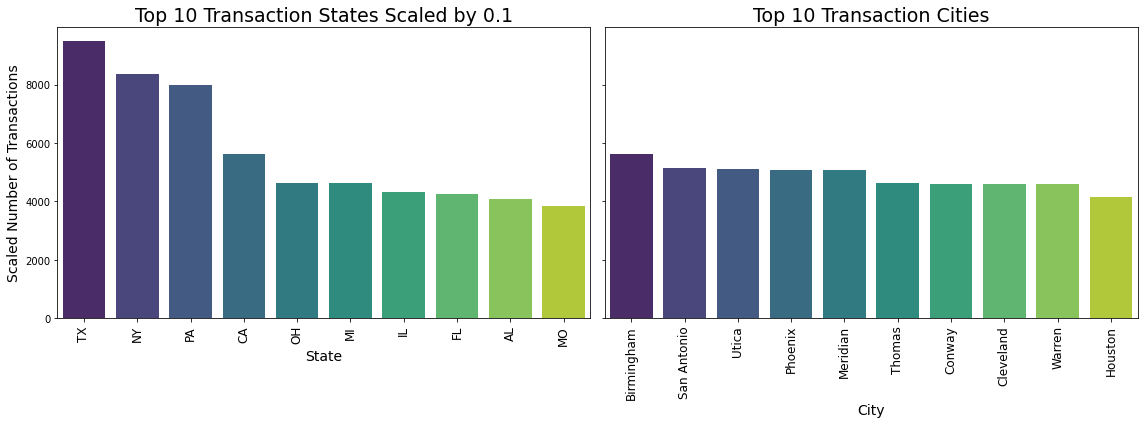

In [14]:
import matplotlib.pyplot as plt

# Calculate top 10 states and cities
scaled_state_counts_top_10 = df['state'].value_counts().sort_values(ascending=False)[:10]
city_counts_top_10 = df['city'].value_counts().sort_values(ascending=False)[:10]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for states (scaled by 0.1)
sns.barplot(x=scaled_state_counts_top_10.index, y=scaled_state_counts_top_10.values / 10, ax=axes[0], palette="viridis")
axes[0].set_title('Top 10 Transaction States Scaled by 0.1', fontsize=19)
axes[0].set_xlabel('State', fontsize=14)
axes[0].set_ylabel('Scaled Number of Transactions', fontsize=14)
axes[0].tick_params(axis='x', rotation=90, labelsize=12)

# Plot for cities
sns.barplot(x=city_counts_top_10.index, y=city_counts_top_10.values, ax=axes[1], palette="viridis")
axes[1].set_title('Top 10 Transaction Cities', fontsize=19)
axes[1].set_xlabel('City', fontsize=14)
axes[1].tick_params(axis='x', rotation=90, labelsize=12)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

Question: do merchants have multiple locations due to type or size of business? The same name of merchant has multple locations across the country(not really close, few hours of drive)

In [15]:
# Get unique merchant locations
unique_locations = df[['merchant', 'merch_lat', 'merch_long', 'city', 'state']]
unique_locations[unique_locations['merchant']=='fraud_Kilback LLC'].head(3)

,merchant,merch_lat,merch_long,city,state
185,fraud_Kilback LLC,42.465418,-95.211895,Avoca,IA
290,fraud_Kilback LLC,41.182138,-98.751918,Fullerton,NE
378,fraud_Kilback LLC,41.009400,-77.925017,Emporium,PA


In [16]:
transaction_map = FraudMap(df[(df['city']=="Paauilo") & (df["is_fraud"] == 1)]).run(port=8041)

In [17]:
# fraud_transactions = df[df["is_fraud"] == 1]
# fraud_map = FraudMap(fraud_transactions).run(port=8040)

### Transaction by Age

In [18]:
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
df["trans_date_trans_time"] = pd.to_datetime(
    df["trans_date_trans_time"], errors="coerce"
)
df["age"] = (df["trans_date_trans_time"] - df["dob"]).dt.days // 365

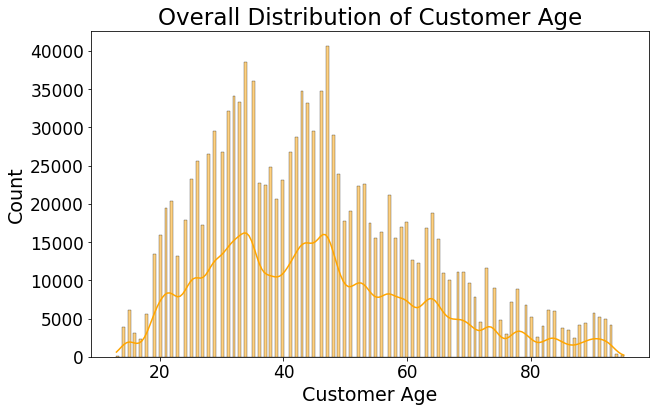

In [19]:
plt.figure(figsize=(10,6))

plt.xlabel('Customer Age', fontsize=19)
plt.ylabel('Count', fontsize=19)

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.title('Overall Distribution of Customer Age', fontsize=23)

sns.histplot(data = df, x=df['age'], kde=True, color='orange')

plt.show()

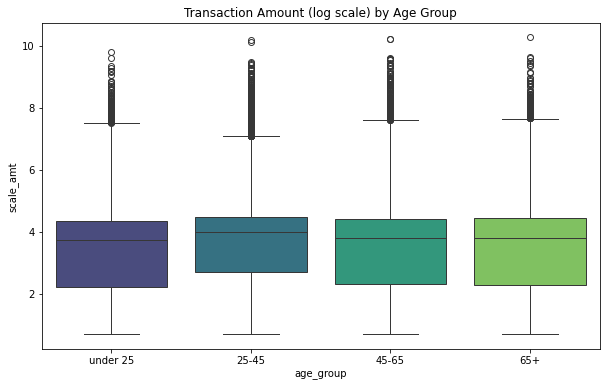

In [20]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100], labels=['under 25', '25-45', '45-65', '65+'])
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='age_group', y='scale_amt', palette='viridis')
plt.title('Transaction Amount (log scale) by Age Group')
plt.show()

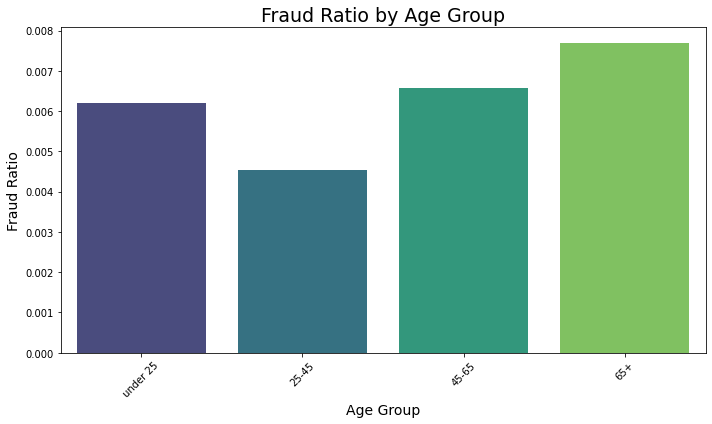

In [21]:
age_group_fraud_ratio = df.groupby("age_group")["is_fraud"].mean().reset_index()
labels=['under 25', '25-45', '45-65', '65+']
# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=age_group_fraud_ratio, x="age_group", y="is_fraud", palette="viridis")

# Add title and labels
plt.title("Fraud Ratio by Age Group", fontsize=19)
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Fraud Ratio", fontsize=14)

# Update x-tick labels if needed (in case of specific age group formatting)
plt.xticks(ticks=range(len(age_group_fraud_ratio)), labels=labels, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Transaction by Gender

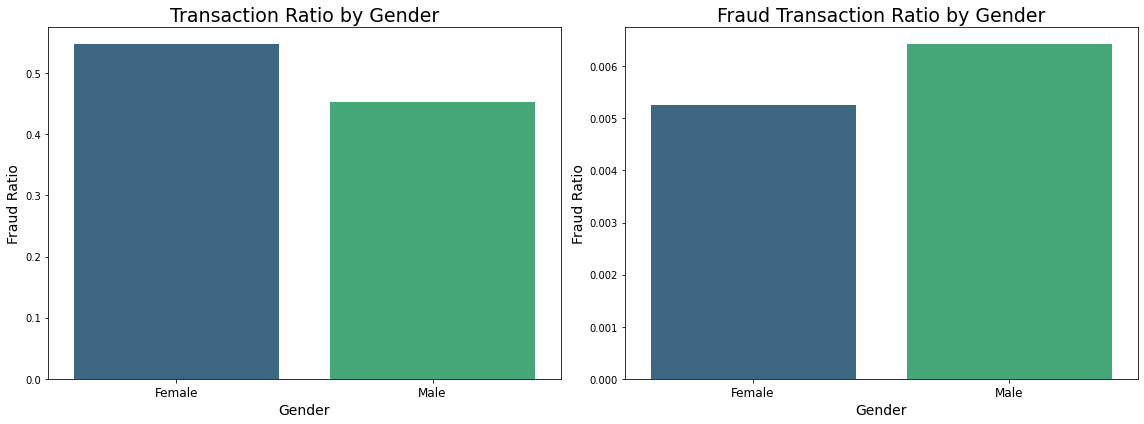

In [22]:
# Calculate the fraud ratio by gender (count-based)
transaction_by_gender = df.groupby("gender")["is_fraud"].count().reset_index()
transaction_by_gender["is_fraud"] = transaction_by_gender["is_fraud"] / transaction_by_gender["is_fraud"].sum()

# Calculate the fraud ratio by gender (mean-based)
fraud_ratio_by_gender = df.groupby("gender")["is_fraud"].mean().reset_index()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot the fraud ratio by gender (count-based)
sns.barplot(x=transaction_by_gender["gender"], y=transaction_by_gender["is_fraud"], ax=axes[0], palette="viridis")
axes[0].set_title("Transaction Ratio by Gender", fontsize=19)
axes[0].set_xlabel("Gender", fontsize=14)
axes[0].set_ylabel("Fraud Ratio", fontsize=14)
axes[0].set_xticklabels(["Female", "Male"], fontsize=12)
axes[0].tick_params(axis='x', rotation=0, labelsize=12)

# Plot the fraud ratio by gender (mean-based)
sns.barplot(x=fraud_ratio_by_gender["gender"], y=fraud_ratio_by_gender["is_fraud"], ax=axes[1], palette="viridis")
axes[1].set_title("Fraud Transaction Ratio by Gender", fontsize=19)
axes[1].set_xlabel("Gender", fontsize=14)
axes[1].set_ylabel("Fraud Ratio", fontsize=14)
axes[1].set_xticklabels(["Female", "Male"], fontsize=12)
axes[1].tick_params(axis='x', rotation=0, labelsize=12)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Transaction by Job

In [23]:
df['job'].value_counts()

Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Ship broker                      7
Contracting civil engineer       7
Warehouse manager                7
Name: job, Length: 494, dtype: int64

The job feature is an ambigious colum with over 490 unique values. To start with, I divide the jobs into 12 categories with the help from Gemini 1.5 pro: 
1. Healthcare & Medical
2. Engineering & Technology
3. Finance, Banking & Insurance
4. Education & Research
5. Creative Arts, Design & Media
6. Legal & Public Sector
7. Business, Management & Consultancy
8. Science & Research
9. Logistics, Transport & Supply Chain
10. Construction & Property
11. Hospitality, Tourism & Leisure
12. Other\

More details can be found in [Feature Engineering](https://github.com/ichbinlan99/Fraud-Detection-TR/blob/eda/notebooks/eda_data_prep.ipynb)

In [24]:
# Load job normalisation gazetteer
with open('../jobs_by_category.json', 'r') as f:
    job_categories = json.load(f)
df_cat_job = categorize_jobs(df, "job", job_categories)

In [25]:
df_cat_job["job_category"].value_counts()

Creative Arts, Design & Media          241736
Healthcare & Medical                   205011
Engineering & Technology               185319
Science & Research                     143293
Finance, Banking & Insurance           100085
Education & Research                    99511
Legal & Public Sector                   98271
Business, Management & Consultancy      95223
Construction & Property                 79889
Hospitality, Tourism & Leisure          33423
Logistics, Transport & Supply Chain     14914
Name: job_category, dtype: int64

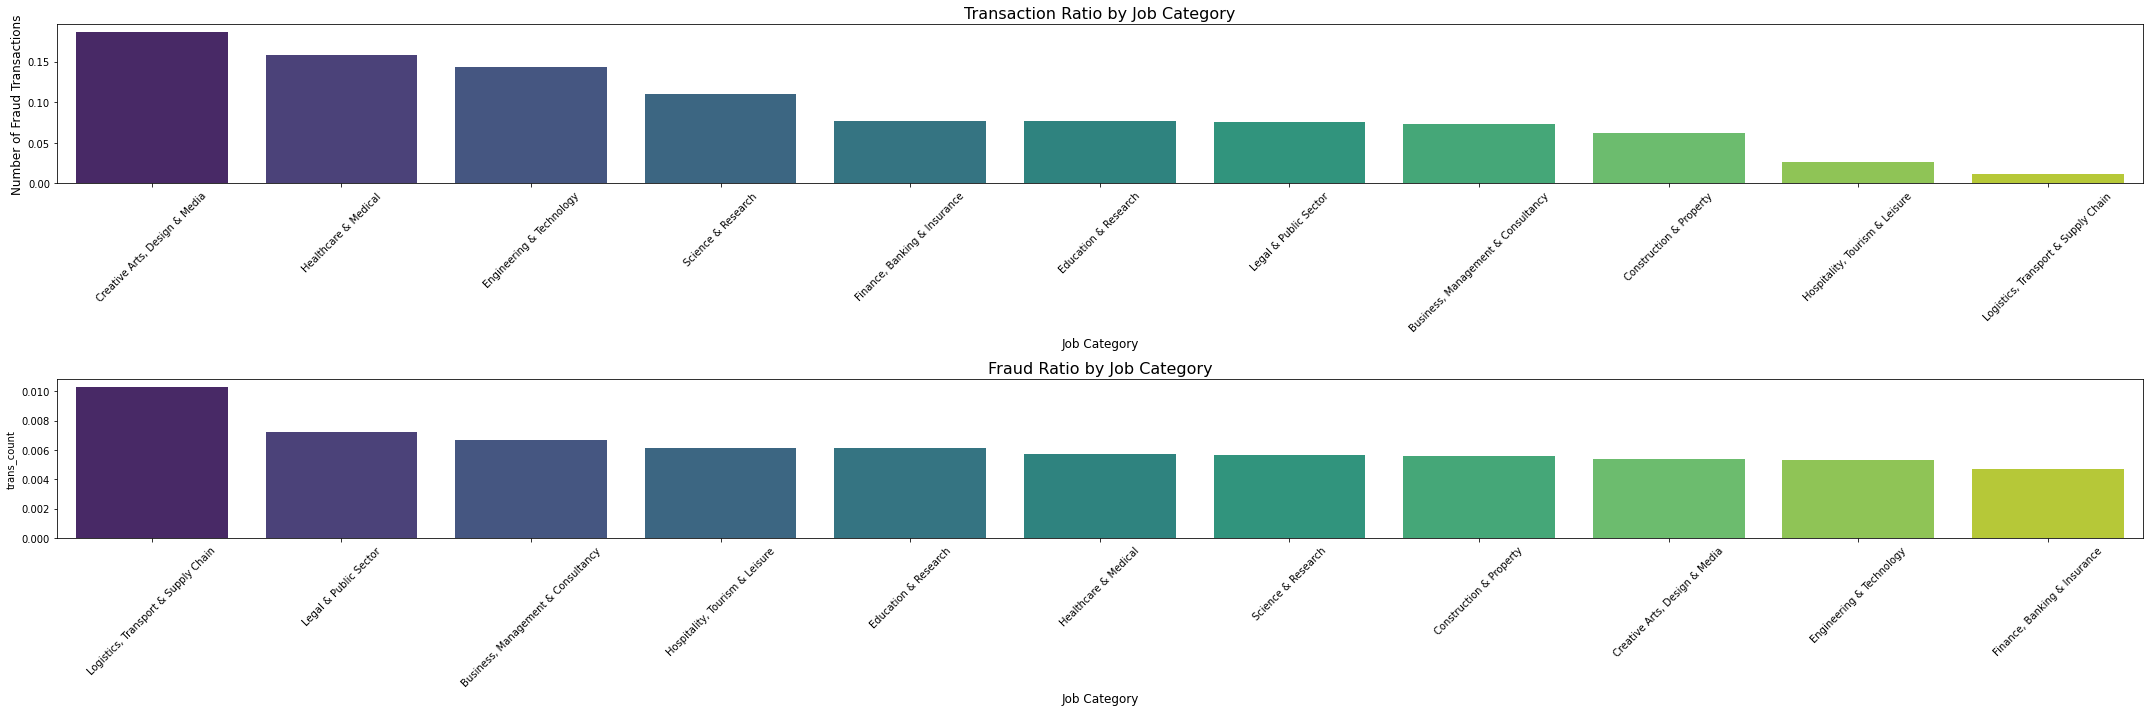

In [26]:
# Assuming df_cat_job is your dataframe containing the job category data

# Calculate fraud count by job category
transaction_by_job_category = df_cat_job.groupby("job_category")["is_fraud"].count().reset_index(name="trans_count")
transaction_by_job_category = transaction_by_job_category.sort_values(by="trans_count", ascending=False)
# Normalize transaction count by job category
transaction_by_job_category["trans_count"] = transaction_by_job_category["trans_count"] / transaction_by_job_category["trans_count"].sum()

# Calculate fraud ratio by job category
fraud_by_job_category = df_cat_job.groupby("job_category")["is_fraud"].mean().reset_index(name="trans_count")
fraud_by_job_category = fraud_by_job_category.sort_values(by="trans_count", ascending=False)

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(30, 10), sharey=False)

# Plot fraud count by job category
sns.barplot(data=transaction_by_job_category, x="job_category", y="trans_count", ax=axes[0], palette="viridis")
axes[0].set_title("Transaction Ratio by Job Category", fontsize=16)
axes[0].set_xlabel("Job Category", fontsize=12)
axes[0].set_ylabel("Number of Fraud Transactions", fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

# Plot fraud ratio by job category
sns.barplot(data=fraud_by_job_category, x="job_category", y="trans_count", ax=axes[1], palette="viridis")
axes[1].set_title("Fraud Ratio by Job Category", fontsize=16)
axes[1].set_xlabel("Job Category", fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Transaction by Merchant Category

In [27]:
df.category.unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

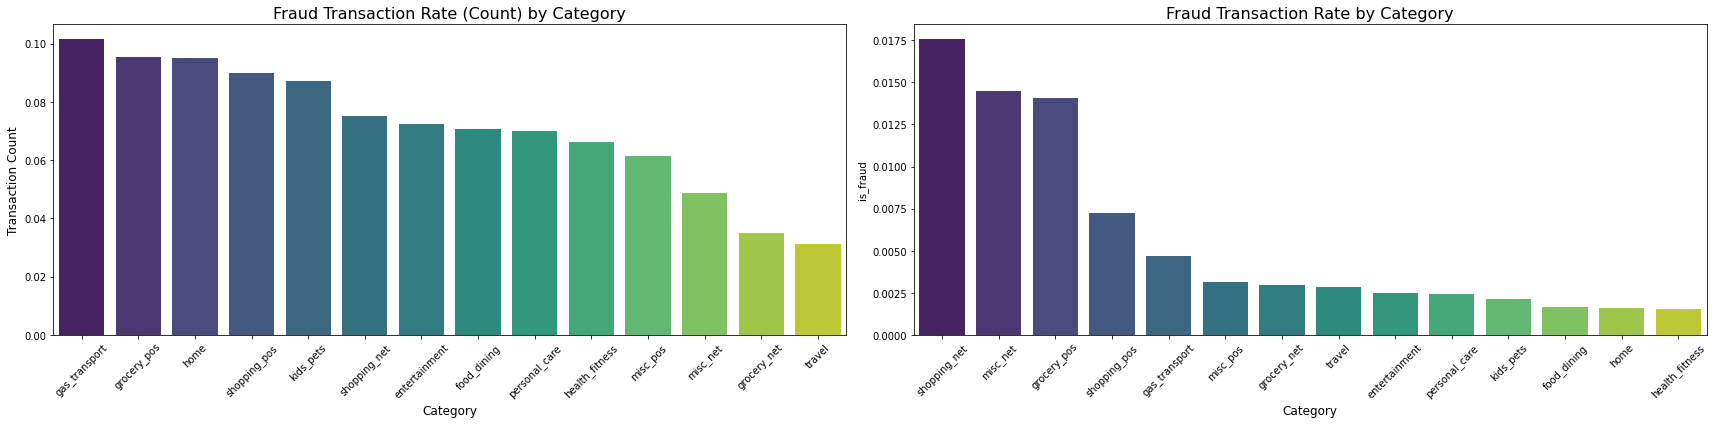

In [28]:
# Calculate the fraud transaction count by category
transaction_by_category = df.groupby("category")["is_fraud"].count().reset_index()
transaction_by_category = transaction_by_category.sort_values(by="is_fraud", ascending=False)
transaction_by_category["fraud_count"] = transaction_by_category["is_fraud"] / transaction_by_category["is_fraud"].sum()

# Calculate the fraud rate by category
fraud_rate_by_category = df.groupby("category")["is_fraud"].mean().reset_index()
fraud_rate_by_category = fraud_rate_by_category.sort_values(by="is_fraud", ascending=False)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=False)

# Plot for fraud transaction rate (count) by category
sns.barplot(data=transaction_by_category, x="category", y="fraud_count", ax=axes[0], palette="viridis")
axes[0].set_title("Fraud Transaction Rate (Count) by Category", fontsize=16)
axes[0].set_xlabel("Category", fontsize=12)
axes[0].set_ylabel("Transaction Count", fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

# Plot for fraud rate by category
sns.barplot(data=fraud_rate_by_category, x="category", y="is_fraud", ax=axes[1], palette="viridis")
axes[1].set_title("Fraud Transaction Rate by Category", fontsize=16)
axes[1].set_xlabel("Category", fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

# Adjust x-axis tick positions to align
axes[0].set_xticks(range(len(transaction_by_category)))
axes[1].set_xticks(range(len(fraud_rate_by_category)))

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## Bivariate Analysis

### Age v.s Amount

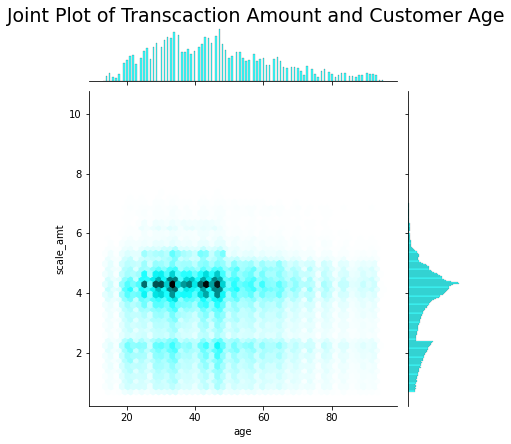

In [29]:
sns.jointplot(x='age', y='scale_amt', data=df, kind='hex', color='aqua')
plt.suptitle('Joint Plot of Transcaction Amount and Customer Age', y=1.02, fontsize=19)
plt.show()

### Gender v.s Amount

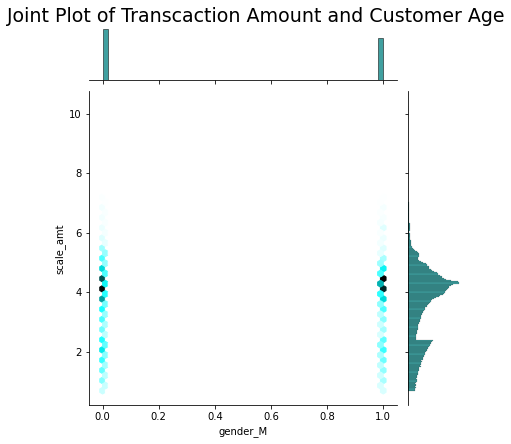

In [30]:
df_enc_gender, _ = encode(df, "gender", "gender", encoding = "onehot")
sns.jointplot(x='gender_M', y='scale_amt', data=df_enc_gender, kind='hex', color='teal')
plt.suptitle('Joint Plot of Transcaction Amount and Customer Age', y=1.02, fontsize=19)
plt.show()

## Multivariate Analysis

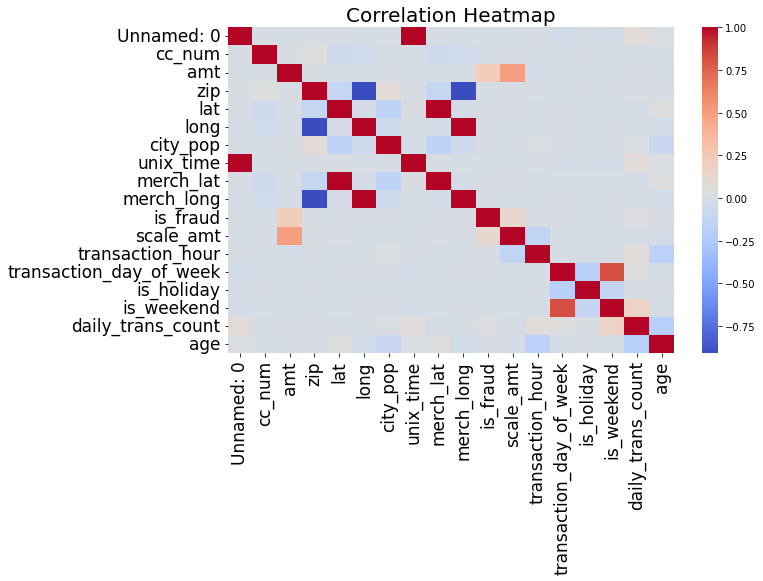

In [31]:
# this will be updated after feature engineering
plt.figure(figsize=(10,6))

numeric_columns = df.select_dtypes(include=np.number).columns

correlation_matrix = df[numeric_columns].corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90, fontsize=17)
plt.yticks(fontsize=17)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

## Outlook

For further research, one could refine the EDA by adding:
- reduce the dimension of data and visualise to see if the generated synthetic data show patterns on lower dimensional space (tsne, pca, dbscan,...)

- calculate quantitively on a time window of data distributional shifts using KL divergence

- causal analysis on direct and early caused of a transaction being flagged using dynamic causal discovery (this still remain as higher level actiona and require demanding domain knowledge)

- anomaly detection to remove outliers

- ... 